In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import sklearn
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Cleaning data + adding variables

In [18]:
wth = pd.read_csv("weatherHistory.csv")

wth.drop_duplicates(inplace=True)
wth.drop("Loud Cover", axis=1, inplace=True)
wth.drop("Apparent Temperature (C)", axis=1, inplace=True)
wth.drop("Daily Summary", axis=1, inplace=True)
wth.drop("Summary", axis=1, inplace=True)



dates = pd.DataFrame(wth["Formatted Date"].apply(lambda x: x[:10]).value_counts())
down_index = dates.loc[dates["Formatted Date"] < 24].index
for i in down_index:
    wth = wth[~(wth["Formatted Date"].str.startswith(i))]
upper_index = dates.loc[dates["Formatted Date"] > 24].index
for i in upper_index:
    wth = wth[~(wth["Formatted Date"].str.startswith(i))]

In [19]:
precip_mask = {
    "rain" : 0,
    "snow" : 1
}
wth.replace({"Precip Type": precip_mask}, inplace=True)
wth.drop(wth[wth["Pressure (millibars)"] < 1].index, inplace=True)


wth["hour"] = wth["Formatted Date"].apply(lambda x: x[10:13])
wth["hour"] = wth["hour"].astype(int)

In [20]:
wth["Month"] = wth["Formatted Date"].apply(lambda x: x[5:7])
wth["Month"] = wth["Month"].astype(int)



In [21]:
wth.drop("Formatted Date", inplace=True, axis=1)

upper_lim = wth["Temperature (C)"].quantile(.95)
lower_lim = wth["Temperature (C)"].quantile(.05)
wth = wth[(wth["Temperature (C)"] < upper_lim) & (wth["Temperature (C)"] > lower_lim)]

In [22]:
len(wth[wth["Temperature (C)"] < -10].index)

0

<AxesSubplot:xlabel='Temperature (C)', ylabel='Count'>

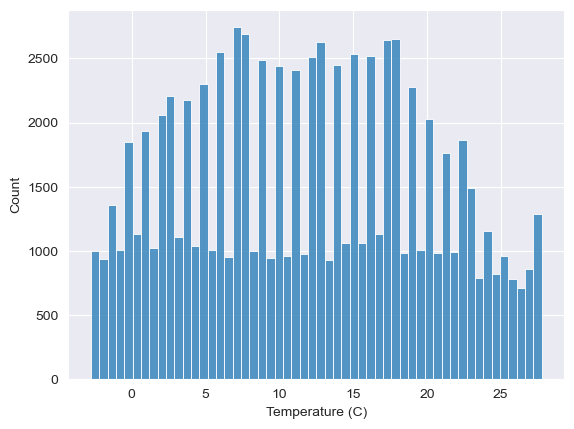

In [23]:
sns.histplot(data=wth, x="Temperature (C)")

<AxesSubplot:xlabel='Humidity', ylabel='Count'>

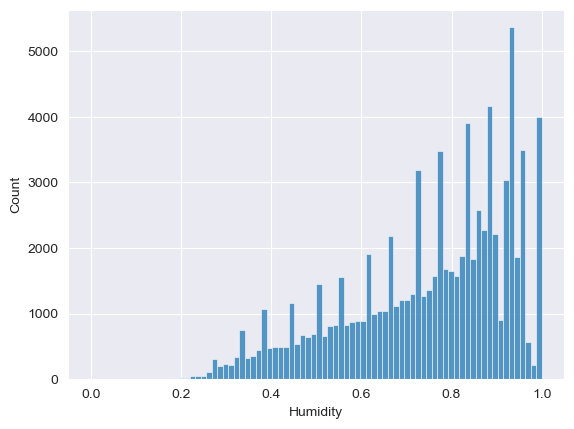

In [24]:
sns.histplot(data=wth, x="Humidity")

In [25]:
len(wth[wth["Humidity"] < 0.3].index)

849

In [26]:
wth = wth[(wth["Humidity"] > 0.3)]

In [45]:
wth.dropna(inplace=True)

In [46]:
wth = wth[(wth["Pressure (millibars)"] > 990)]

<AxesSubplot:xlabel='Visibility (km)', ylabel='Count'>

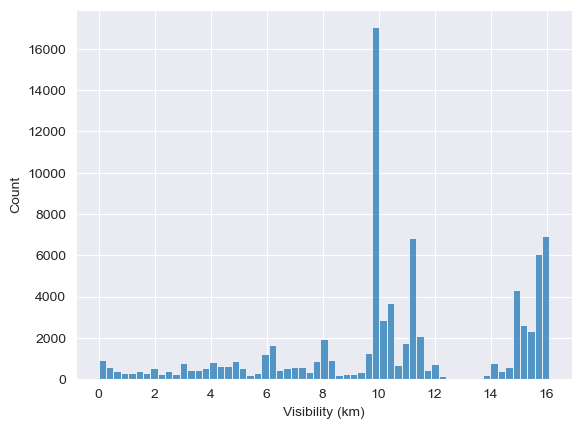

In [47]:
sns.histplot(data=wth, x="Visibility (km)")

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
# wth.drop("Visibility (km)", axis=1, inplace=True)

In [50]:
X = wth[["Precip Type", "Humidity", "Pressure (millibars)", "Visibility (km)"]]
y = wth["Temperature (C)"]

# Linear regression

In [51]:
summary_df = pd.DataFrame()
column_list = []
for j in range(1, 7):
    X_train, X_test, y_train, y_test = train_test_split(wth.drop("Temperature (C)", axis=1), wth["Temperature (C)"], test_size=0.2)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    summary_df = pd.concat([summary_df, pd.DataFrame({"mse": [mse]})])
    rfe = RFE(model, n_features_to_select=j)
    rfe.fit(X_train, y_train)
    columns = []
    for i, col in enumerate(X_train.columns):
        if rfe.support_[i]:
            columns.append(col)
    print(f"{j} most important column(s): {columns}")
    column_list.append(columns)

1 most important column(s): ['Humidity']
2 most important column(s): ['Precip Type', 'Humidity']
3 most important column(s): ['Precip Type', 'Humidity', 'Month']
4 most important column(s): ['Precip Type', 'Humidity', 'Pressure (millibars)', 'Month']
5 most important column(s): ['Precip Type', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)', 'Month']
6 most important column(s): ['Precip Type', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)', 'Month']


In [64]:
summary_df = pd.DataFrame()
for i in column_list:
    X_train, X_test, y_train, y_test = train_test_split(wth[i], wth["Temperature (C)"], test_size=0.2)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    summary_df = pd.concat([summary_df, pd.DataFrame({"mse": [mse], "columns": [len(i)]})])

In [69]:
summary_df.head(6) #As we can see, if there are more features, the lower the value of the cost function becomes.

,mse,columns
0,42.751662,1
0,35.382556,2
0,34.729336,3
0,31.318595,4
0,29.232884,5
0,27.892198,6


In [58]:
summary_df = pd.DataFrame()
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(wth.drop("Temperature (C)", axis=1), wth["Temperature (C)"], test_size=0.15)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    summary_df = pd.concat([summary_df, pd.DataFrame({"mse": [mse]})])

In [59]:
summary_df["mse"].mean()

28.268784419673132

#  The linear regression model is too simple for such a complex problem. The high value of the cost function clearly indicates the fact that it is not an appropriate model.